In [1]:
from copy import deepcopy

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from neurasort.preprocessing import free_whisking_preprocessing_pipe

In [6]:
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC

from sklearn.inspection import permutation_importance

In [3]:
raw_predictors_free_whisking = pd.read_csv("raw_predictors_free_whisking.csv")
raw_predictors_free_whisking.drop("Cell_tdTomatoExpressing", axis=1, inplace=True)
preprocessing_pipe = free_whisking_preprocessing_pipe()
class_weights = (1 - raw_predictors_free_whisking["cell_type"].value_counts() / raw_predictors_free_whisking["cell_type"].shape[0]).to_dict()
raw_predictors_free_whisking

,cell_type,firing_rate,ap_threshold,ap_duration,mean_vm,std_vm,fft_low,fft_high,Cell_APThreshold_Slope,Cell_Depth,Cell_Layer
0,EXC,3.25,-0.028422,0.563846,-0.038375,0.005196,0.000043,0.000518,10.0,229.0,L2/3
1,EXC,0.20,-0.033953,1.012500,-0.049049,0.004335,0.000053,0.000485,10.0,350.0,L2/3
2,EXC,0.05,-0.039291,3.350000,-0.050940,0.005286,0.000063,0.000519,10.0,350.0,L2/3
3,EXC,0.00,0.000000,0.000000,-0.047544,0.004778,0.000057,0.000557,10.0,350.0,L2/3
4,EXC,0.15,-0.033361,1.733333,-0.046490,0.002881,0.000031,0.000403,10.0,244.0,L2/3
...,...,...,...,...,...,...,...,...,...,...,...
492,SST,6.60,-0.047992,0.564015,-0.056633,0.003752,0.000066,0.000438,20.0,196.0,L2/3
493,SST,6.80,-0.047427,0.578676,-0.056827,0.004175,0.000071,0.000514,20.0,196.0,L2/3
494,SST,7.50,-0.047400,0.589667,-0.056011,0.004038,0.000067,0.000460,20.0,196.0,L2/3
495,SST,5.50,-0.048279,0.580455,-0.056918,0.003525,0.000054,0.000430,20.0,196.0,L2/3


In [4]:
X = raw_predictors_free_whisking.drop("cell_type", axis=1)
y = raw_predictors_free_whisking["cell_type"]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2',
 '#7f7f7f', '#bcbd22', '#17becf', "#422d96", "#80186b"]#, "#b54f00"]

In [5]:
gbclf_pipe = deepcopy(preprocessing_pipe)
gbclf_pipe.steps.append(
    ("clf", GradientBoostingClassifier(
            random_state=0, 
            learning_rate=0.01770111473542578, 
            n_estimators=434
        )
    )
)

svclf_pipe = deepcopy(preprocessing_pipe)
svclf_pipe.steps.append(
    ("clf", LinearSVC(
            random_state=0,
            C=17.311433293929746,
            max_iter=500,
            class_weight=class_weights,
            multi_class='crammer_singer',
            penalty="l2",
            dual='auto',
        )
    )
)

rfclf_pipe = deepcopy(preprocessing_pipe)
rfclf_pipe.steps.append(
    ("clf", RandomForestClassifier(
            random_state=0, 
            class_weight=class_weights,
            criterion='entropy',
            n_estimators=236
        )
    )
)

In [6]:
model_names = ["GB", "SVM", "RF"]
models = [gbclf_pipe, svclf_pipe, rfclf_pipe]
for model_name, model in zip(model_names, models):
    scores = cross_val_score(
        estimator=model,
        X=X,
        y=y,
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=0),
        scoring="f1_weighted"
    )
    print(f"{model_name}: mean = {scores.mean()}, std = {scores.std()}")

GB: mean = 0.9132717043991129, std = 0.025752713517605733


/Users/wesleymonteith/miniconda3/envs/bio482/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/wesleymonteith/miniconda3/envs/bio482/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/wesleymonteith/miniconda3/envs/bio482/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/wesleymonteith/miniconda3/envs/bio482/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/wesleymonteith/miniconda3/envs/bio482/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  

SVM: mean = 0.9113916233380026, std = 0.033184727827692495
RF: mean = 0.9274853120001383, std = 0.037850645396222224


In [7]:
model_names = ["GB", "SVM", "RF"]
models = [gbclf_pipe, svclf_pipe, rfclf_pipe]
preds = []
for model_name, model in zip(model_names, models):
    pred = cross_val_predict(
        estimator=model,
        X=X,
        y=y,
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=0),
    )
    preds.append(pred)

/Users/wesleymonteith/miniconda3/envs/bio482/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/wesleymonteith/miniconda3/envs/bio482/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/wesleymonteith/miniconda3/envs/bio482/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/wesleymonteith/miniconda3/envs/bio482/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/wesleymonteith/miniconda3/envs/bio482/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  

In [26]:
from sklearn.metrics import confusion_matrix, accuracy_score

/var/folders/my/2hxsh9b90b9brv55p9f5x2700000gn/T/ipykernel_68464/1553876926.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(np.unique(y))
/var/folders/my/2hxsh9b90b9brv55p9f5x2700000gn/T/ipykernel_68464/1553876926.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(np.unique(y))
/var/folders/my/2hxsh9b90b9brv55p9f5x2700000gn/T/ipykernel_68464/1553876926.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(np.unique(y))


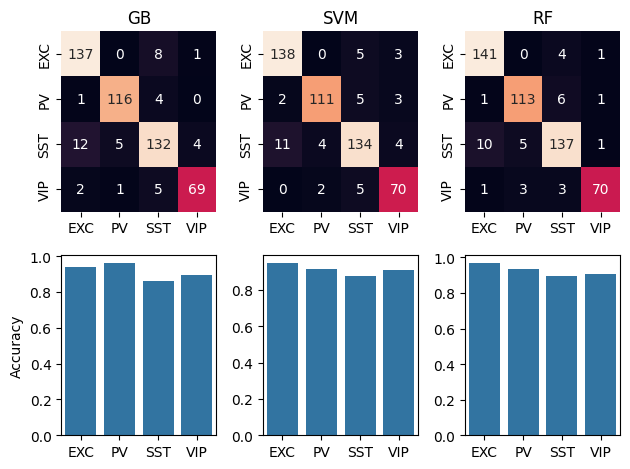

In [52]:
fig, axes = plt.subplots(nrows=2, ncols=3)
for i, ax in enumerate(axes.flatten()):
    
    if i <= 2:
        cfs_mat = confusion_matrix(y, preds[i])
        sns.heatmap(cfs_mat, annot=True, fmt='g', ax=ax, cbar=False)
        ax.set_xticklabels(np.unique(y))
        ax.set_yticklabels(np.unique(y))
        ax.set_title(f"{model_names[i]}")
    if i > 2:
        cfs_mat = confusion_matrix(y, preds[i-3])
        sns.barplot(data=cfs_mat.diagonal()/cfs_mat.sum(axis=1), ax=ax) 
        ax.set_xticklabels(np.unique(y))
        if i == 3:
            ax.set_ylabel("Accuracy")
          
    
plt.tight_layout()

In [28]:
accuracy_score(y, preds[0])

0.9134808853118712

array(['EXC', 'PV', 'SST', 'VIP'], dtype=object)

In [18]:
confusion_matrix(y, preds[1], labels=np.unique(y))

array([[138,   0,   5,   3],
       [  2, 111,   5,   3],
       [ 11,   4, 134,   4],
       [  0,   2,   5,  70]])

In [11]:
confusion_matrix(y, preds[2])

array([[141,   0,   4,   1],
       [  1, 113,   6,   1],
       [ 10,   5, 137,   1],
       [  1,   3,   3,  70]])

# Gradient Boosting

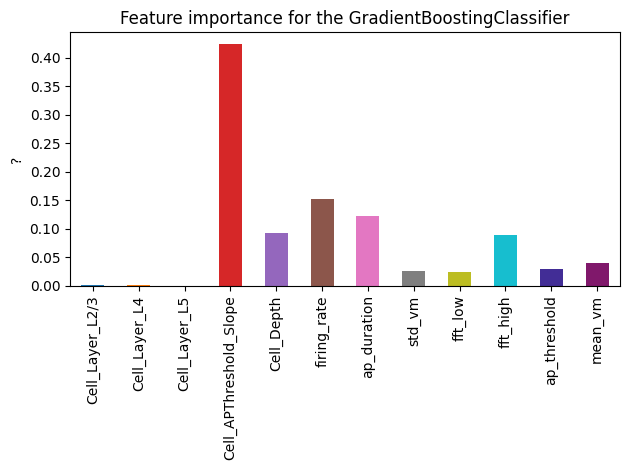

In [7]:
gbclf_pipe.fit(X, y)
fig, ax = plt.subplots()

gb_impotances = pd.Series(gbclf_pipe.named_steps.clf.feature_importances_, index=gbclf_pipe.named_steps.clf.feature_names_in_)
gb_impotances.plot.bar(ax=ax, color=colors)
ax.set_title(f"Feature importance for the GradientBoostingClassifier")
ax.set_ylabel("?")
fig.tight_layout()
plt.show()
plt.show()

In [8]:
gbclf_pipe.named_steps.clf.estimators_.shape

(434, 4)

# SVM

https://stackoverflow.com/questions/41592661/determining-the-most-contributing-features-for-svm-classifier-in-sklearn

/Users/wesleymonteith/miniconda3/envs/bio482/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


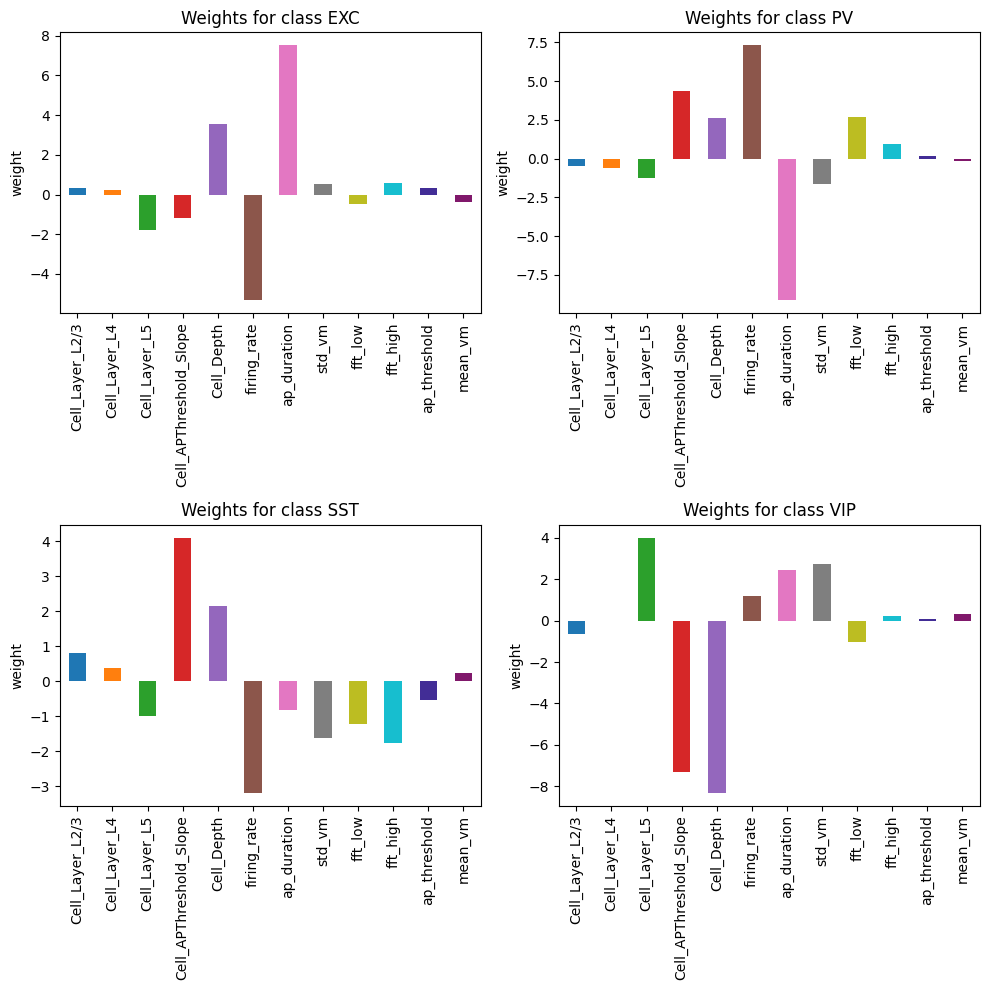

In [9]:
svclf_pipe.fit(X, y)
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(10, 10))
for i, ax in enumerate(axes.flatten()):
    svm_impotances = pd.Series(svclf_pipe.named_steps.clf.coef_[i], index=svclf_pipe.named_steps.clf.feature_names_in_)
    svm_impotances.plot.bar(ax=ax, color=colors)
    ax.set_title(f"Weights for class {svclf_pipe.named_steps.clf.classes_[i]}")
    ax.set_ylabel("weight")
    # for i in ax.containers:
    #     ax.bar_label(
    #         i,
    #     )
fig.tight_layout()
plt.show()
plt.show()

/Users/wesleymonteith/miniconda3/envs/bio482/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


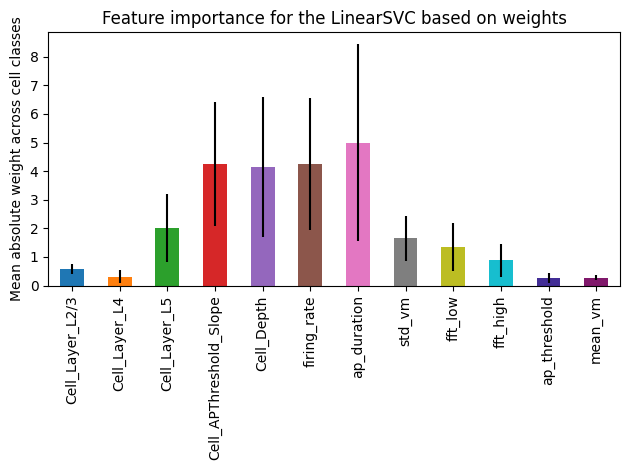

In [10]:
svclf_pipe.fit(X, y)
fig, ax = plt.subplots()

svm_impotances = pd.Series(np.mean(np.abs(svclf_pipe.named_steps.clf.coef_), axis=0), index=svclf_pipe.named_steps.clf.feature_names_in_)
std = np.std(np.abs(svclf_pipe.named_steps.clf.coef_), axis=0)
svm_impotances.plot.bar(ax=ax, color=colors, yerr=std)
ax.set_title(f"Feature importance for the LinearSVC based on weights")
ax.set_ylabel("Mean absolute weight across cell classes")
fig.tight_layout()
plt.show()
plt.show()

In [12]:
# sns.countplot(
#     data=raw_predictors_free_whisking,
#     x="Cell_tdTomatoExpressing",
#     hue="cell_type"
# )

# Random Forest

https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

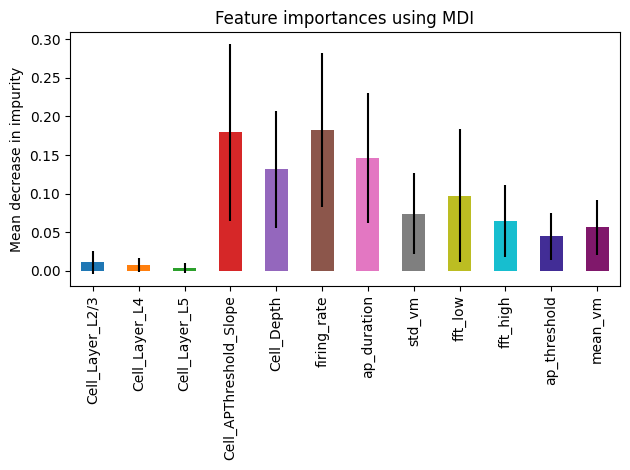

In [13]:
rfclf_pipe.fit(X, y)
importances = rfclf_pipe.named_steps.clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfclf_pipe.named_steps.clf.estimators_], axis=0)
forest_importances = pd.Series(importances, index=rfclf_pipe.named_steps.clf.feature_names_in_)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax, color=colors)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
plt.show()

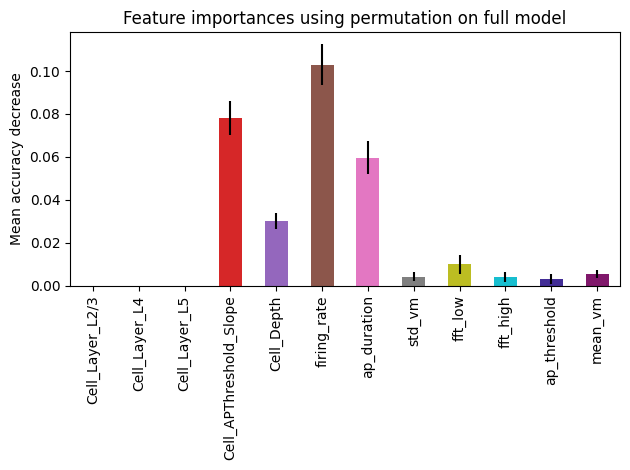

In [14]:
result = permutation_importance(
    rfclf_pipe.named_steps.clf, preprocessing_pipe.fit_transform(X), y, n_repeats=10, random_state=42, n_jobs=2, sample_weight=raw_predictors_free_whisking["cell_type"].apply(lambda x : class_weights[x])
)
forest_importances = pd.Series(result.importances_mean, index=rfclf_pipe.named_steps.clf.feature_names_in_)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax, color=colors)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()